# Lab Session 2

The objectives of this lab session are the following:
- Visualize augmented data samples
- Experiment with Data Augmentation
- Implement mixup in your training loop

All experiments done on CIFAR10.

---
## Part 1 - Visualization of DA

Data augmentation (DA) in Pytorch 

In [1]:
from datetime import datetime
import numpy as np 
from matplotlib.pylab import plt
import gc
import polars as pl
import time

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data.dataloader import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split
from models_cifar100 import *

In [2]:


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

rootdir = './data/cifar10'

c10train = CIFAR10(rootdir,train=True,download=True,transform=transform_train)
c10test = CIFAR10(rootdir,train=False,download=True,transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


DA here is done by two random transformations : 
- [RandomCrop](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomCrop.html), which crops the image at a random location and pads the borders, and 
- [RandomHorizontalFlip](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomHorizontalFlip.html#torchvision.transforms.RandomHorizontalFlip).

A few important notes :
- ToTensor() converts the images to torch Tensors
- Normalization is performed so that the input values follow the normal distribution
- DA is applied only for the training set. For the test set, only normalization is applied


In order to visualize, let's define Dataloaders with a small batch, and we will remove Shuffling so that we can always look at the same images. We also remove normalization so that we preserve the pixel values for plotting. 


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 3, 32, 32)


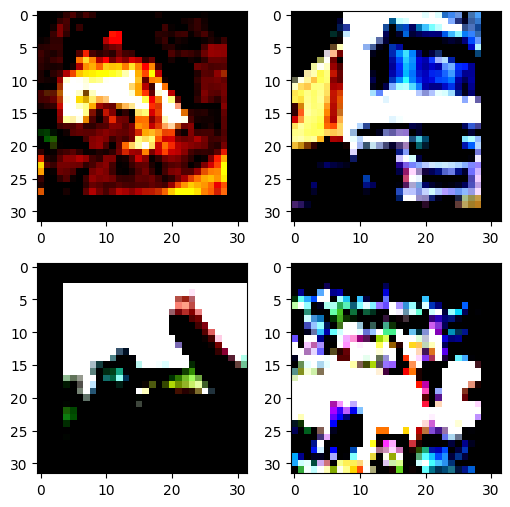

In [3]:


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomEqualize(0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

rootdir = './data/cifar10'

c10train = CIFAR10(rootdir,train=True,download=True,transform=transform_train)

trainloader = DataLoader(c10train,batch_size=4,shuffle=False) ### Shuffle to False so that we always see the same images

from matplotlib import pyplot as plt 

### Let's do a figure for each batch
f = plt.figure(figsize=(6,6))

for i,(data,target) in enumerate(trainloader):
    
    data = (data.numpy())
    print(data.shape)
    plt.subplot(2,2,1)
    plt.imshow(data[0].swapaxes(0,2).swapaxes(0,1))
    plt.subplot(2,2,2)
    plt.imshow(data[1].swapaxes(0,2).swapaxes(0,1))
    plt.subplot(2,2,3)
    plt.imshow(data[2].swapaxes(0,2).swapaxes(0,1))
    plt.subplot(2,2,4)
    plt.imshow(data[3].swapaxes(0,2).swapaxes(0,1))

    break

f.savefig('train_DA.png')

And you should obtain an image similar to this one : 

![Image](train_DA.png)

... except that the crops and flips will be different each time you run the code.

A few things to try : 
- Remove one of the two transformations and see the effect
- Experiment with other transformations, available from  [torchvision.transforms](https://pytorch.org/vision/main/transforms.html#transforms-on-pil-image-and-torch-tensor). 
- Don't forget that you should not change the image size as a result of transformation. 
- There are also some popular packages for data augmentations such as albumentations, including a more detailed pytorch tutorial [here](https://albumentations.ai/docs/examples/pytorch_classification/). You can check out more examples of DA strategies there. 




## Part 2 - Experiments with DA
You can now customize DA into your learning pipeline. Don't forget to check that you have normalization in the list of transforms, and to shuffle the train set (we removed those for pedagogical purposes here).

The set of DA used here comes from the [repo for CIFAR10](https://github.com/kuangliu/pytorch-cifar/blob/master/main.py) we have been using since the beginning and can achieve close to SOTA, but when trying to reduce parameter count you might be able to boost performances by including more DA.




## Part 3 - Mixup

Mixup was introduced in 2017 in [this paper](https://arxiv.org/abs/1710.09412). 

A simple way to perform mixup during training is the following procedure. This replaces your usual training loop. 

For each batch with data and target $X,y$ :
- Generate another order of data and targets: $X_{perm},y_{perm}$ by permuting the indices
- Generate a random scalar $\lambda \in [0,1]$. The uniform distribution is a good default choice, obtained by simply doing `lambda = random.random()` from the random standard python library.
- The mixed-up data is $X_{m} = \lambda X + (1-\lambda)X_{perm}$
- Zero gradients, forward pass with the mixed up data : $out_m = model(X_{m})$
- Compute the loss as follows (CE is cross-entropy) : $loss = \lambda CE(out_m,y) + (1-\lambda) CE(out_m,y_{perm})$
- Backward pass and optimizer step as would be done without mixup.

You should leave the option to activate mixup or not during an epoch, as performing mixup since the beginning may harm training, depending on architectures and datasets. 

You will find other ways to do it in the litterature (e.g. sampling $\lambda$ from the distribution $\Gamma(\alpha,\alpha)$ with various values of $\alpha$).  The procedure proposed here the advantage of having no hyperparameters, as $\lambda$ is chosen uniformly in $[0,1]$, which also ensures that some batches will not have mixup.


Implement this mechanism and see the effect on training on CIFAR10.

N.B. : there is an important difference between the [actual implementation](https://github.com/facebookresearch/mixup-cifar10/blob/main/train.py#L119) provided by the authors (which correspond more or less to what is described here) and the formula in [the paper](https://arxiv.org/abs/1710.09412) ; targets in the paper are a linear interpolation of the two targets (hence mixed up targets are not one hot), while the implementation performs a linear interpolation of the loss with mixed up data. 


In [4]:
device = torch.device('cuda:2')

In [5]:
## Normalization adapted for CIFAR10
normalize_scratch = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

# Transforms is a list of transformations applied on the 'raw' dataset before the data is fed to the network. 
# Here, Data augmentation (RandomCrop and Horizontal Flip) are applied to each batch, differently at each epoch, on the training set data only
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize_scratch,
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize_scratch,
])

In [6]:
rootdir = './data/cifar10'

dataset = CIFAR10(rootdir,train=True,download=True,transform=transform_train)
test_dataset = CIFAR10(rootdir,train=False,download=True,transform=transform_test)

torch.manual_seed(43)
val_size = int(len(dataset)*0.1)
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

Files already downloaded and verified
Files already downloaded and verified


(45000, 5000)

In [7]:
train_loader = DataLoader(train_ds,batch_size=32,shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=32) 

In [8]:
def mixup_data(x, y, alpha=1.0):
    '''see https://github.com/facebookresearch/mixup-cifar10/blob/main/train.py#L151'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [9]:
def train_one_epoch(model, optimizer, epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    model.train(True)
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels =inputs.to(device),labels.to(device)
        inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha)
        inputs, targets_a, targets_b = map(Variable, (inputs, targets_a, targets_b))
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    last_loss = running_loss / len(train_loader) # loss per batch
    #print('  batch {} loss: {}'.format(i + 1, last_loss))
    tb_x = epoch_index * len(train_loader) + i + 1
    tb_writer.add_scalar('Loss/train', last_loss, tb_x)
    return last_loss

In [10]:
def validate_epoch(model, val_loader, criterion):
    running_vloss = 0.0
    model.eval()
    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss
    return running_vloss

In [11]:
def train_model(model, model_name, optimizer, save_models=False, use_scheduler=False):
    print(model_name)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    avg_train_losses=[]
    avg_val_losses = []
    epoch_number = 0
    best_vloss = 1_000_000.

    writer = SummaryWriter(f'runs/lab2_{model_name}_{learning_rate}_{timestamp}_{epoch_number}')
    
    if use_scheduler:
        # Create a ReduceLROnPlateau scheduler - updates learning rate of the optimizer
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
        
    for epoch in range(EPOCHS):
        avg_loss = train_one_epoch(model, optimizer, epoch_number, writer)
        running_vloss = 0.0

        # Disable gradient computation and reduce memory consumption.
        running_vloss = validate_epoch(model, val_loader, criterion)
        if use_scheduler:
            scheduler.step(running_vloss)
            # Check if the learning rate was reduced
            #if scheduler.optimizer.param_groups[0]['lr'] < 0.1:
            #    print("Learning rate reduced to:", scheduler.optimizer.param_groups[0]['lr'])
    
        avg_vloss = (running_vloss / (len(val_loader))).item()
        print(f'Epoch: {epoch_number + 1}, Loss train: {avg_loss}, valid: {avg_vloss}')
        avg_train_losses.append(avg_loss)
        avg_val_losses.append(avg_vloss)
    
        # Log the running loss averaged per batch
        # for both training and validation
        writer.add_scalars('Training vs. Validation Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss },
                        epoch_number + 1)
        writer.flush()
    

    
        epoch_number += 1
    torch.cuda.empty_cache() 
    gc.collect()
    return avg_train_losses, avg_val_losses

In [12]:
EPOCHS = 5
learning_rate = 0.01
momentum = 0.9  # The momentum parameter (typically between 0 and 1)
alpha = 0.9

In [13]:
criterion = nn.CrossEntropyLoss()

In [14]:
model = VGG('VGG16')
model_name='VGG16'

start_time=time.time()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
avg_train_losses, avg_val_losses, best_test_acc = train_model(model, model_name, optimizer, save_models=False, use_scheduler=True)
print(f'{model_name}, train loss: {avg_train_losses}, val loss: {avg_val_losses}, elapsed: {time.time()-start_time}')

VGG16
Epoch: 1, Loss train: 2.102530878066339, valid: 1.619508981704712
Epoch: 2, Loss train: 1.8103443539218862, valid: 1.327063798904419
Epoch: 3, Loss train: 1.6342713740927663, valid: 1.1495611667633057
Epoch: 4, Loss train: 1.510565650403796, valid: 0.997810423374176
Epoch: 5, Loss train: 1.4552439176705854, valid: 0.9200946092605591


ValueError: not enough values to unpack (expected 3, got 2)